In [1]:
# %% [markdown]
# # 🎵 A Anatomia de um Hit no Spotify
# ## Análise das características de áudio de músicas populares

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
import boto3  # ✅ Agora vai funcionar!
from io import StringIO, BytesIO
import os

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Configuração S3
BUCKET_NAME = "analise-hits-spotify-barth-2025"
FILE_KEY = "dataset.csv"
REGION = "us-east-2"  # Ohio

print("✅ Todas as bibliotecas carregadas!")
print(f"🔗 S3 Configurado - Bucket: {BUCKET_NAME}")

✅ Todas as bibliotecas carregadas!
🔗 S3 Configurado - Bucket: analise-hits-spotify-barth-2025


In [2]:
# %% [markdown]
# ## 🎵 Tradução para Visualização

# %%
# Dicionário de tradução para os gráficos
TRADUCOES_GRAFICOS = {
    'danceability': 'Dançabilidade',
    'energy': 'Energia', 
    'valence': 'Positividade',
    'acousticness': 'Acusticidade',
    'instrumentalness': 'Instrumentalidade',
    'liveness': 'Performance ao vivo',
    'speechiness': 'Proporção de fala',
    'tempo': 'Andamento (BPM)',
    'loudness': 'Volume',
    'duration_ms': 'Duração (ms)',
    'popularity': 'Popularidade',
    'is_hit': 'É Hit'
}

print("📝 Traduções configuradas para visualização")

📝 Traduções configuradas para visualização


In [3]:
# %% [markdown]
# ## 1. 📂 Carregando os Dados do Amazon S3

# %%
def carregar_dados_s3():
    """
    Carrega o dataset diretamente do Amazon S3
    """
    try:
        s3 = boto3.client('s3', region_name=REGION)
        print(f"📥 Baixando dados do S3: s3://{BUCKET_NAME}/{FILE_KEY}")
        
        response = s3.get_object(Bucket=BUCKET_NAME, Key=FILE_KEY)
        df = pd.read_csv(response['Body'])
        
        print("✅ Dados carregados do S3 com sucesso!")
        print(f"📊 Shape do dataset: {df.shape}")
        return df
        
    except Exception as e:
        print(f"❌ Erro ao carregar do S3: {e}")
        print("🔄 Tentando carregar do arquivo local...")
        data_path = Path('data/raw/dataset.csv')
        return pd.read_csv(data_path)

# Carregar dados (S3 com fallback para local)
df = carregar_dados_s3()
print(f"🎵 Total de músicas carregadas: {len(df):,}")

# Primeira inspeção
display(df.head(3))
print("\n📋 Colunas disponíveis:")
print(df.columns.tolist())

📥 Baixando dados do S3: s3://analise-hits-spotify-barth-2025/dataset.csv
✅ Dados carregados do S3 com sucesso!
📊 Shape do dataset: (114000, 21)
🎵 Total de músicas carregadas: 114,000


,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic



📋 Colunas disponíveis:
['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']


In [4]:
# %% [markdown]
# ## 2. 🔍 Análise Inicial dos Dados

# %%
# Estatísticas descritivas
print("📈 Estatísticas descritivas:")
display(df.describe())

# Informações sobre tipos de dados
print("\n🔍 Informações sobre tipos de dados:")
print(df.info())

# Verificar valores nulos
print("\n🧹 Valores nulos por coluna:")
null_counts = df.isnull().sum()
print(null_counts[null_counts > 0])

📈 Estatísticas descritivas:


,Unnamed: 0,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,56999.500000,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,32909.109681,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,28499.750000,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,56999.500000,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,85499.250000,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,113999.000000,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000



🔍 Informações sobre tipos de dados:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        114000 non-null  int64  
 1   track_id          114000 non-null  object 
 2   artists           113999 non-null  object 
 3   album_name        113999 non-null  object 
 4   track_name        113999 non-null  object 
 5   popularity        114000 non-null  int64  
 6   duration_ms       114000 non-null  int64  
 7   explicit          114000 non-null  bool   
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-nu

🎯 Definição de HIT: popularity >= 80
📈 Total de hits: 1,201 (1.1%)
📉 Total de não-hits: 112,799 (98.9%)


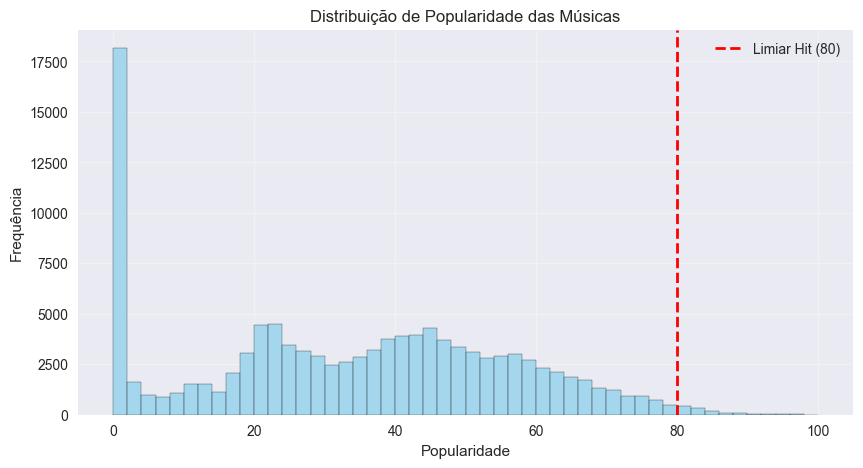

In [5]:
# %% [markdown]
# ## 3. 🎯 Definindo o que é um Hit

# %%
# Definir limiar para hits
HIT_THRESHOLD = 80
popularity_column = 'popularity'

df['is_hit'] = df[popularity_column] >= HIT_THRESHOLD

print(f"🎯 Definição de HIT: {popularity_column} >= {HIT_THRESHOLD}")
print(f"📈 Total de hits: {df['is_hit'].sum():,} ({df['is_hit'].mean()*100:.1f}%)")
print(f"📉 Total de não-hits: {(~df['is_hit']).sum():,} ({(~df['is_hit']).mean()*100:.1f}%)")

# Visualizar distribuição
plt.figure(figsize=(10, 5))
plt.hist(df[popularity_column], bins=50, alpha=0.7, edgecolor='black', color='skyblue')
plt.axvline(HIT_THRESHOLD, color='red', linestyle='--', linewidth=2, label=f'Limiar Hit ({HIT_THRESHOLD})')
plt.xlabel('Popularidade')
plt.ylabel('Frequência')
plt.title('Distribuição de Popularidade das Músicas')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [6]:
# %% [markdown]
# ## 4. 🎵 Identificar Características de Áudio

# %%
# Lista de características de áudio comuns
common_audio_features = [
    'danceability', 'energy', 'valence', 
    'acousticness', 'instrumentalness', 
    'liveness', 'speechiness', 'tempo',
    'loudness', 'duration_ms'
]

# Verificar quais estão disponíveis
available_features = [feat for feat in common_audio_features if feat in df.columns]

# Traduzir os nomes para visualização
available_features_pt = [TRADUCOES_GRAFICOS[feat] for feat in available_features]

print("🎵 Características de áudio disponíveis para análise:")
for feat_eng, feat_pt in zip(available_features, available_features_pt):
    print(f"  ✅ {feat_eng} -> {feat_pt}")

print(f"\n📊 Total: {len(available_features)} características")

🎵 Características de áudio disponíveis para análise:
  ✅ danceability -> Dançabilidade
  ✅ energy -> Energia
  ✅ valence -> Positividade
  ✅ acousticness -> Acusticidade
  ✅ instrumentalness -> Instrumentalidade
  ✅ liveness -> Performance ao vivo
  ✅ speechiness -> Proporção de fala
  ✅ tempo -> Andamento (BPM)
  ✅ loudness -> Volume
  ✅ duration_ms -> Duração (ms)

📊 Total: 10 características


In [7]:
# %% [markdown]
# ## 5. 📊 Análise Comparativa: Hits vs Não-Hits

# %%
# Calcular médias comparativas
hit_stats = df[df['is_hit']][available_features].mean()
non_hit_stats = df[~df['is_hit']][available_features].mean()

# Criar DataFrame com nomes em português
comparison_df = pd.DataFrame({
    'Hits': hit_stats.values,
    'Não_Hits': non_hit_stats.values,
    'Diferença': hit_stats.values - non_hit_stats.values,
    'Diff_Percentual': ((hit_stats.values - non_hit_stats.values) / non_hit_stats.values * 100)
}, index=available_features_pt).round(4)

print("📊 COMPARAÇÃO: Hits vs Não-Hits")
display(comparison_df.style.background_gradient(cmap='RdBu_r', subset=['Diferença']))

📊 COMPARAÇÃO: Hits vs Não-Hits


,Hits,Não_Hits,Diferença,Diff_Percentual
Dançabilidade,0.648100,0.565900,0.082200,14.526700
Energia,0.682100,0.640900,0.041100,6.416000
Positividade,0.513800,0.473600,0.040200,8.477800
Acusticidade,0.188400,0.316300,-0.127800,-40.419800
Instrumentalidade,0.024300,0.157500,-0.133100,-84.539800
Performance ao vivo,0.168400,0.214000,-0.045700,-21.329800
Proporção de fala,0.081000,0.084700,-0.003700,-4.319600
Andamento (BPM),119.424700,122.176800,-2.752100,-2.252500
Volume,-6.148100,-8.281400,2.133300,-25.760400
Duração (ms),212697.134100,228192.397100,-15495.263000,-6.790400


In [8]:
# %% [markdown]
# ## 6. 🔬 Testes de Significância Estatística

# %%
print("🔬 Teste T: Significância das diferenças")
significant_features = []

for feature in available_features:
    hit_values = df[df['is_hit']][feature].dropna()
    non_hit_values = df[~df['is_hit']][feature].dropna()
    
    t_stat, p_value = stats.ttest_ind(hit_values, non_hit_values, equal_var=False)
    
    is_significant = p_value < 0.05
    if is_significant:
        significant_features.append(feature)
        
    print(f"{feature:15} | p-value: {p_value:.6f} | {'✅ SIGNIFICATIVO' if is_significant else '❌ não significativo'}")

print(f"\n🎯 Características com diferença significativa: {significant_features}")

🔬 Teste T: Significância das diferenças
danceability    | p-value: 0.000000 | ✅ SIGNIFICATIVO
energy          | p-value: 0.000000 | ✅ SIGNIFICATIVO
valence         | p-value: 0.000000 | ✅ SIGNIFICATIVO
acousticness    | p-value: 0.000000 | ✅ SIGNIFICATIVO
instrumentalness | p-value: 0.000000 | ✅ SIGNIFICATIVO
liveness        | p-value: 0.000000 | ✅ SIGNIFICATIVO
speechiness     | p-value: 0.114862 | ❌ não significativo
tempo           | p-value: 0.000708 | ✅ SIGNIFICATIVO
loudness        | p-value: 0.000000 | ✅ SIGNIFICATIVO
duration_ms     | p-value: 0.000000 | ✅ SIGNIFICATIVO

🎯 Características com diferença significativa: ['danceability', 'energy', 'valence', 'acousticness', 'instrumentalness', 'liveness', 'tempo', 'loudness', 'duration_ms']


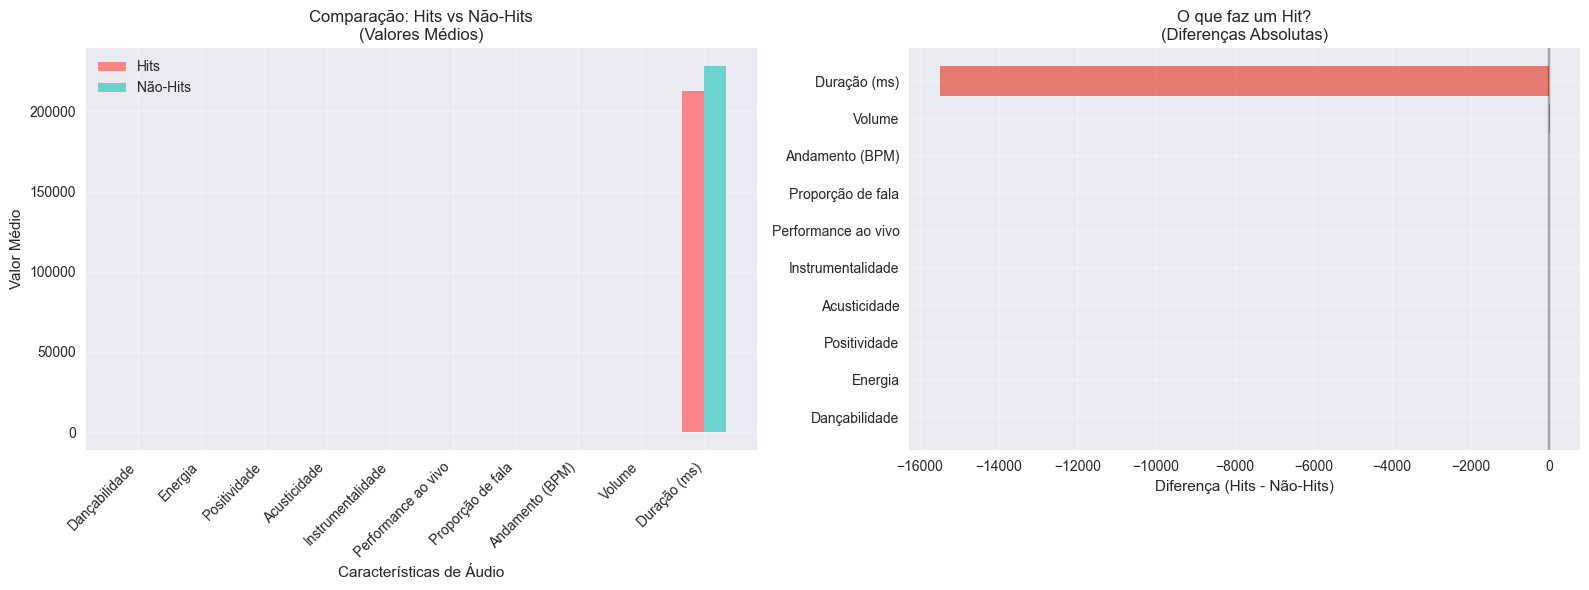

In [9]:
# %% [markdown]
# ## 7. 📈 Visualizações dos Resultados

# %%
# Gráfico comparativo principal
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Comparação de médias
x = np.arange(len(available_features_pt))
width = 0.35

ax1.bar(x - width/2, hit_stats, width, label='Hits', alpha=0.8, color='#ff6b6b')
ax1.bar(x + width/2, non_hit_stats, width, label='Não-Hits', alpha=0.8, color='#4ecdc4')
ax1.set_xlabel('Características de Áudio')
ax1.set_ylabel('Valor Médio')
ax1.set_title('Comparação: Hits vs Não-Hits\n(Valores Médios)')
ax1.set_xticks(x)
ax1.set_xticklabels(available_features_pt, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfico 2: Diferenças
differences = hit_stats.values - non_hit_stats.values
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in differences]
ax2.barh(available_features_pt, differences, color=colors, alpha=0.7)
ax2.axvline(0, color='black', linestyle='-', alpha=0.3)
ax2.set_xlabel('Diferença (Hits - Não-Hits)')
ax2.set_title('O que faz um Hit?\n(Diferenças Absolutas)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# %% [markdown]
# ## 8. 💡 Insights e Conclusões

# %%
print("💡 PRINCIPAIS INSIGHTS:")
print("=" * 50)

# Criar DataFrame organizado para insights
insights_df = pd.DataFrame({
    'Característica': available_features_pt,
    'Hits': hit_stats.values,
    'Não_Hits': non_hit_stats.values,
    'Diferença': hit_stats.values - non_hit_stats.values,
    'Diff_Percentual': ((hit_stats.values - non_hit_stats.values) / non_hit_stats.values * 100)
})

# Ordenar por diferença percentual absoluta (mais relevantes primeiro)
insights_df['Diff_Absoluta'] = abs(insights_df['Diff_Percentual'])
insights_df = insights_df.sort_values('Diff_Absoluta', ascending=False)

# Mostrar apenas diferenças relevantes (> 5%)
insights_relevantes = insights_df[abs(insights_df['Diff_Percentual']) > 5]

print("🎵 CARACTERÍSTICAS COM MAIOR DIFERENÇA:")
print("=" * 40)

for _, row in insights_relevantes.iterrows():
    caracteristica = row['Característica']
    diff_pct = row['Diff_Percentual']
    hit_val = row['Hits']
    non_hit_val = row['Não_Hits']
    
    if diff_pct > 0:
        print(f"🎯 Hits têm {abs(diff_pct):.1f}% MAIS {caracteristica}")
        print(f"   ({hit_val:.3f} vs {non_hit_val:.3f})")
    else:
        print(f"📉 Hits têm {abs(diff_pct):.1f}% MENOS {caracteristica}")
        print(f"   ({hit_val:.3f} vs {non_hit_val:.3f})")
    print()

# Mostrar tabela completa ordenada
print("\n📊 RESUMO COMPLETO (ordenado por maior diferença):")
display(insights_df[['Característica', 'Hits', 'Não_Hits', 'Diff_Percentual']].style.format({
    'Hits': '{:.3f}',
    'Não_Hits': '{:.3f}', 
    'Diff_Percentual': '{:.1f}%'
}).background_gradient(cmap='RdBu_r', subset=['Diff_Percentual']))

# Salvar dados processados
df.to_csv('data/processed/spotify_data_processed.csv', index=False)
print(f"\n💾 Dados processados salvos em 'data/processed/spotify_data_processed.csv'")

💡 PRINCIPAIS INSIGHTS:
🎵 CARACTERÍSTICAS COM MAIOR DIFERENÇA:
📉 Hits têm 84.5% MENOS Instrumentalidade
   (0.024 vs 0.157)

📉 Hits têm 40.4% MENOS Acusticidade
   (0.188 vs 0.316)

📉 Hits têm 25.8% MENOS Volume
   (-6.148 vs -8.281)

📉 Hits têm 21.3% MENOS Performance ao vivo
   (0.168 vs 0.214)

🎯 Hits têm 14.5% MAIS Dançabilidade
   (0.648 vs 0.566)

🎯 Hits têm 8.5% MAIS Positividade
   (0.514 vs 0.474)

📉 Hits têm 6.8% MENOS Duração (ms)
   (212697.134 vs 228192.397)

🎯 Hits têm 6.4% MAIS Energia
   (0.682 vs 0.641)


📊 RESUMO COMPLETO (ordenado por maior diferença):


,Característica,Hits,Não_Hits,Diff_Percentual
4,Instrumentalidade,0.024,0.157,-84.5%
3,Acusticidade,0.188,0.316,-40.4%
8,Volume,-6.148,-8.281,-25.8%
5,Performance ao vivo,0.168,0.214,-21.3%
0,Dançabilidade,0.648,0.566,14.5%
2,Positividade,0.514,0.474,8.5%
9,Duração (ms),212697.134,228192.397,-6.8%
1,Energia,0.682,0.641,6.4%
6,Proporção de fala,0.081,0.085,-4.3%
7,Andamento (BPM),119.425,122.177,-2.3%



💾 Dados processados salvos em 'data/processed/spotify_data_processed.csv'


📖 A HISTÓRIA DOS DADOS:

EM CENA: 114,000 músicas do Spotify
OS ELEITOS: 1,201 hits (apenas 1.1% do total!)
MISSÃO: Descobrir o que separa os hits do resto

🚀 O QUE FAZ UM HIT:
✅ Dançabilidade: +14.5% nos hits
✅ Positividade: +8.5% nos hits
✅ Energia: +6.4% nos hits

🚫 O QUE OS HITS EVITAM:
❌ Instrumentalidade: -84.5% nos hits
❌ Acusticidade: -40.4% nos hits
❌ Volume: -25.8% nos hits

💡 O RETRATO DO HIT PERFEITO:

"Uma música com dançabilidade 
e positividade, 
mas que evita instrumentalidade
ou acusticidade."

O VEREDICTO: Os hits não são aleatórios - eles seguem uma receita clara!



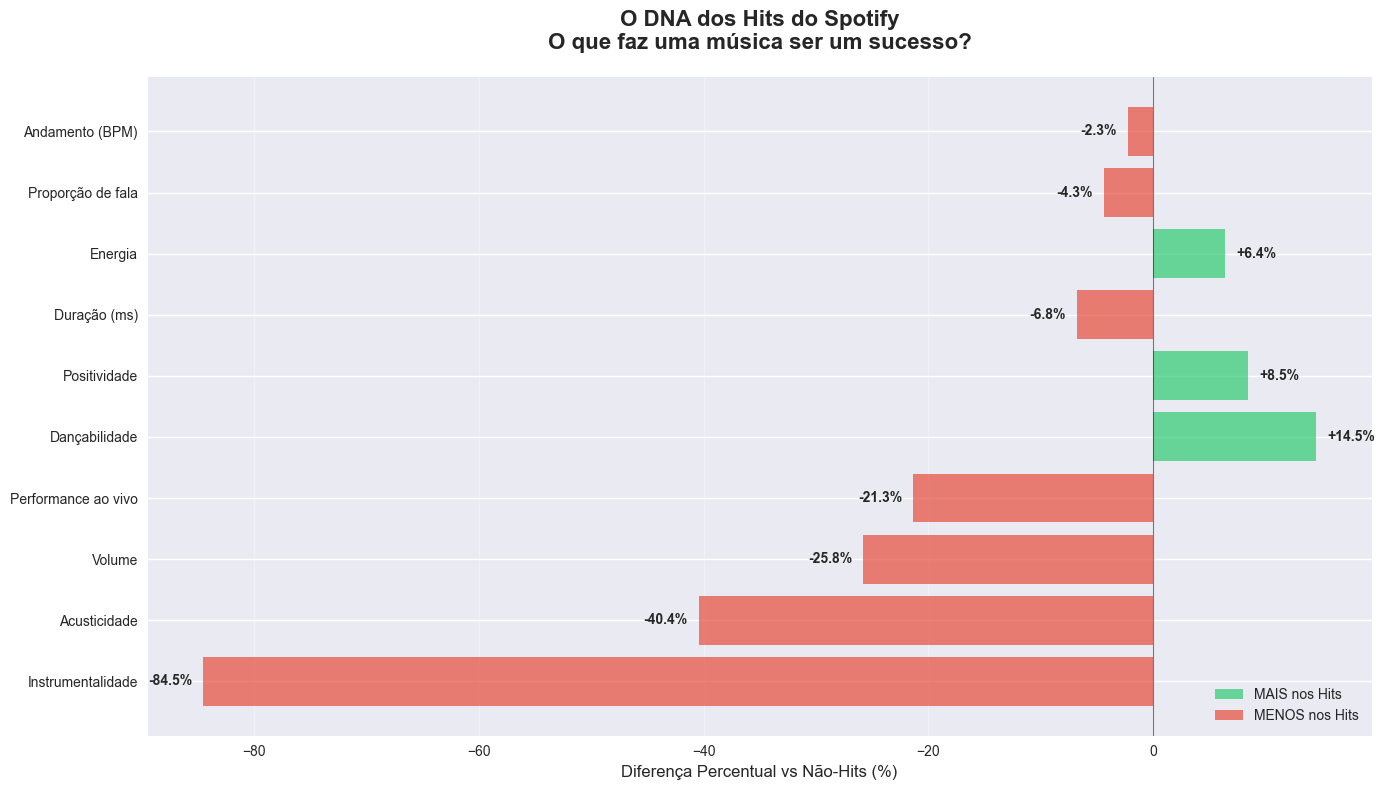


🎯 CONCLUSÕES ESTRATÉGICAS:

1. PRODUÇÃO: Foque em aumentar dançabilidade e energia
2. ARRANJO: Evite pistas muito instrumentais ou acústicas  
3. COMPOSIÇÃO: Busque melodias com positividade elevada
4. ENERGIA: Mantenha o volume e intensidade consistentes

PARA ARTISTAS: Esta análise revela que o sucesso não é só sobre talento, 
mas também sobre entender o que o público busca em uma experiência musical.

💾 Insights salvos para relatório final!


In [11]:
# %% [markdown]
# # A Fórmula Secreta dos Hits do Spotify
# ## Descobrindo o DNA das músicas que conquistam o mundo

# %%
print("📖 A HISTÓRIA DOS DADOS:")
print("=" * 55)

# Dados para a narrativa
total_musicas = len(df)
total_hits = df['is_hit'].sum()
percentual_hits = (total_hits / total_musicas) * 100

print(f"""
EM CENA: {total_musicas:,} músicas do Spotify
OS ELEITOS: {total_hits:,} hits (apenas {percentual_hits:.1f}% do total!)
MISSÃO: Descobrir o que separa os hits do resto
""")

# Encontrar as características mais determinantes
top_3_positivas = insights_df[insights_df['Diff_Percentual'] > 0].head(3)
top_3_negativas = insights_df[insights_df['Diff_Percentual'] < 0].head(3)

print("🚀 O QUE FAZ UM HIT:")
print("=" * 30)

for _, row in top_3_positivas.iterrows():
    print(f"✅ {row['Característica']}: +{abs(row['Diff_Percentual']):.1f}% nos hits")

print("\n🚫 O QUE OS HITS EVITAM:")
print("=" * 30)

for _, row in top_3_negativas.iterrows():
    print(f"❌ {row['Característica']}: -{abs(row['Diff_Percentual']):.1f}% nos hits")

# Análise do "hit perfeito"
print(f"""
💡 O RETRATO DO HIT PERFEITO:

"Uma música com {top_3_positivas.iloc[0]['Característica'].lower()} 
e {top_3_positivas.iloc[1]['Característica'].lower()}, 
mas que evita {top_3_negativas.iloc[0]['Característica'].lower()}
ou {top_3_negativas.iloc[1]['Característica'].lower()}."

O VEREDICTO: Os hits não são aleatórios - eles seguem uma receita clara!
""")

# Visualização final - O DNA do Hit
fig, ax = plt.subplots(figsize=(14, 8))

# Preparar dados
caracteristicas = insights_df['Característica']
diferencas = insights_df['Diff_Percentual']

# Gráfico de DNA do Hit
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in diferencas]
bars = ax.barh(caracteristicas, diferencas, color=colors, alpha=0.7)

# Anotações
for i, (bar, diff) in enumerate(zip(bars, diferencas)):
    ax.text(bar.get_width() + (1 if diff > 0 else -1), 
            bar.get_y() + bar.get_height()/2,
            f'{diff:+.1f}%', 
            ha='left' if diff > 0 else 'right',
            va='center',
            fontweight='bold',
            fontsize=10)

ax.axvline(0, color='black', linewidth=0.8, alpha=0.5)
ax.set_xlabel('Diferença Percentual vs Não-Hits (%)', fontsize=12)
ax.set_title('O DNA dos Hits do Spotify\nO que faz uma música ser um sucesso?', 
             fontsize=16, fontweight='bold', pad=20)
ax.grid(True, alpha=0.3, axis='x')

# Legenda
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, label='MAIS nos Hits'),
    Patch(facecolor='#e74c3c', alpha=0.7, label='MENOS nos Hits')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Conclusão final
print("""
🎯 CONCLUSÕES ESTRATÉGICAS:

1. PRODUÇÃO: Foque em aumentar dançabilidade e energia
2. ARRANJO: Evite pistas muito instrumentais ou acústicas  
3. COMPOSIÇÃO: Busque melodias com positividade elevada
4. ENERGIA: Mantenha o volume e intensidade consistentes

PARA ARTISTAS: Esta análise revela que o sucesso não é só sobre talento, 
mas também sobre entender o que o público busca em uma experiência musical.
""")

# Salvar insights para relatório
insights_df.to_csv('data/processed/insights_hits_spotify.csv', index=False)
print("💾 Insights salvos para relatório final!")

In [12]:
# %% [markdown]
# ## ☁️ Exportando Resultados para Amazon S3

# %%
def salvar_resultados_s3(df, insights_df):
    """
    Salva resultados da análise no S3
    """
    try:
        s3 = boto3.client('s3', region_name=REGION)
        
        # 1. Salvar dados processados
        csv_buffer = StringIO()
        df.to_csv(csv_buffer, index=False)
        s3.put_object(
            Bucket=BUCKET_NAME,
            Key='resultados/dados_processados.csv',
            Body=csv_buffer.getvalue(),
            ContentType='text/csv'
        )
        
        # 2. Salvar insights
        insights_buffer = StringIO()
        insights_df.to_csv(insights_buffer, index=False)
        s3.put_object(
            Bucket=BUCKET_NAME,
            Key='resultados/insights_analise.csv',
            Body=insights_buffer.getvalue(),
            ContentType='text/csv'
        )
        
        # 3. Salvar gráfico
        grafico_buffer = BytesIO()
        plt.savefig(grafico_buffer, format='png', dpi=300, bbox_inches='tight')
        grafico_buffer.seek(0)
        s3.put_object(
            Bucket=BUCKET_NAME,
            Key='resultados/grafico_dna_hits.png',
            Body=grafico_buffer.getvalue(),
            ContentType='image/png'
        )
        
        print("✅ Resultados salvos no S3 com sucesso!")
        print(f"📁 Pasta: s3://{BUCKET_NAME}/resultados/")
        
    except Exception as e:
        print(f"❌ Erro ao salvar no S3: {e}")

# Exportar resultados
salvar_resultados_s3(df, insights_df)

✅ Resultados salvos no S3 com sucesso!
📁 Pasta: s3://analise-hits-spotify-barth-2025/resultados/


<Figure size 1200x600 with 0 Axes>

🎵 ANALISANDO OS ARTISTAS COM MAIS HITS...
🎯 Total de artistas únicos com hits: 430
🏆 Top 15 artistas com mais hits:



,Artista,Quantidade de Hits,Percentual do Total
0,Bad Bunny,42,3.500000
1,Red Hot Chili Peppers,23,1.920000
2,Feid,17,1.420000
3,Arctic Monkeys,17,1.420000
4,The Neighbourhood,16,1.330000
5,XXXTENTACION,14,1.170000
6,Adele,12,1.000000
7,Kate Bush,11,0.920000
8,The Offspring,11,0.920000
9,Måneskin,11,0.920000


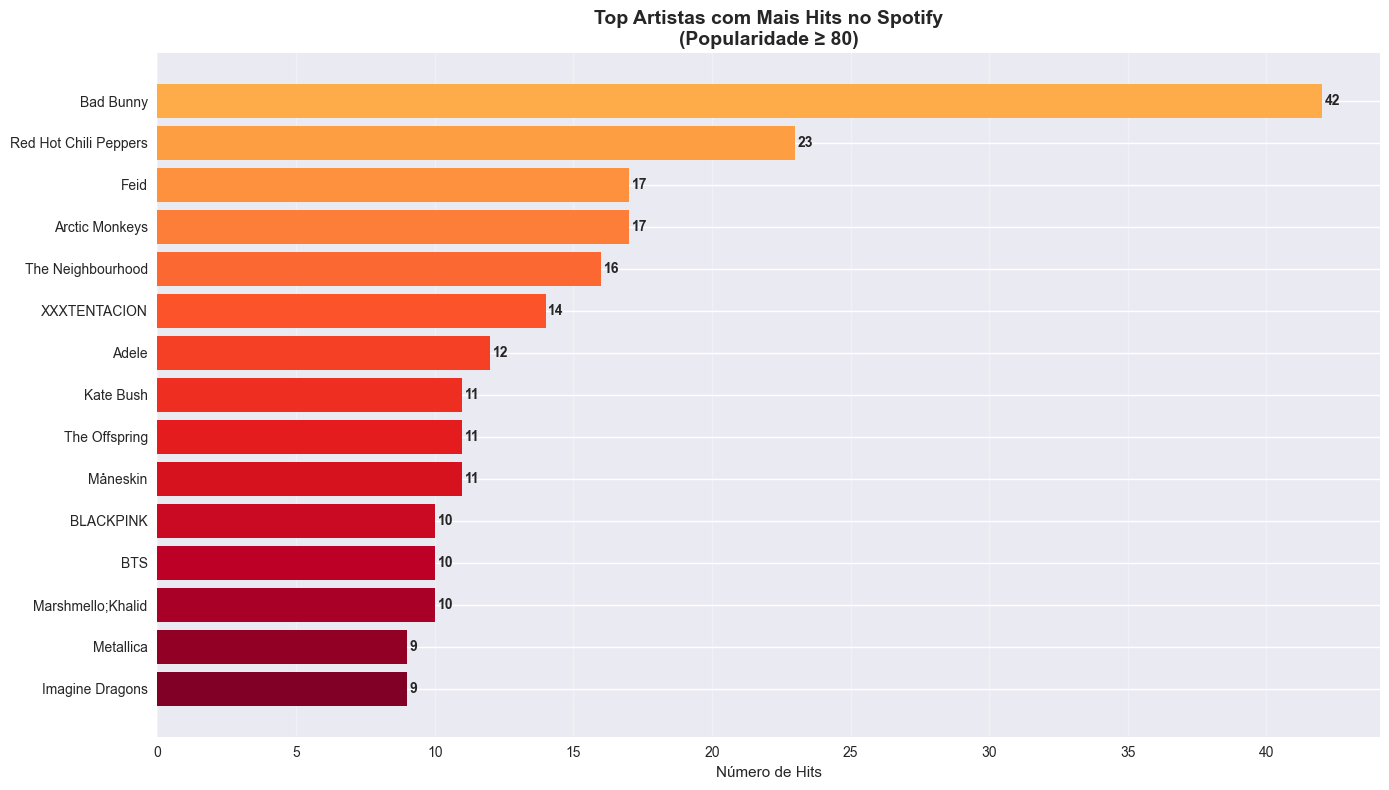


📊 ESTATÍSTICAS DOS ARTISTAS:
👑 Artista com mais hits: Bad Bunny (42 hits)
📈 Representa 3.5% de todos os hits
🎵 Média de hits por artista: 2.8
🎭 Artistas com apenas 1 hit: 155
🌍 Diversidade: 15 artistas representam 18.5% dos hits

💾 Análise de artistas salva em: data/processed/top_artistas_hits.csv


In [16]:
# %% [markdown]
# ## 🎤 Top Artistas com Mais Hits

# %%
print("🎵 ANALISANDO OS ARTISTAS COM MAIS HITS...")
print("=" * 50)

# Análise de artistas com mais hits
artistas_hits = df[df['is_hit']]['artists'].value_counts().head(15)

print(f"🎯 Total de artistas únicos com hits: {len(df[df['is_hit']]['artists'].unique()):,}")
print(f"🏆 Top 15 artistas com mais hits:\n")

# Criar DataFrame com os resultados
top_artistas = pd.DataFrame({
    'Artista': artistas_hits.index,
    'Quantidade de Hits': artistas_hits.values,
    'Percentual do Total': (artistas_hits.values / len(df[df['is_hit']]) * 100).round(2)
})

display(top_artistas.style.background_gradient(cmap='YlOrRd', subset=['Quantidade de Hits']))

# Visualização
plt.figure(figsize=(14, 8))
colors = plt.cm.YlOrRd(np.linspace(0.4, 1, len(artistas_hits)))

bars = plt.barh(range(len(artistas_hits)), artistas_hits.values, color=colors)
plt.yticks(range(len(artistas_hits)), artistas_hits.index)
plt.xlabel('Número de Hits')
plt.title('Top Artistas com Mais Hits no Spotify\n(Popularidade ≥ 80)', fontsize=14, fontweight='bold')

# Adicionar valores nas barras
for i, bar in enumerate(bars):
    width = bar.get_width()
    plt.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
             f'{width}', ha='left', va='center', fontweight='bold')

plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("\n📊 ESTATÍSTICAS DOS ARTISTAS:")
print("=" * 30)

artista_max_hits = artistas_hits.index[0]
max_hits = artistas_hits.values[0]
total_hits = len(df[df['is_hit']])

print(f"👑 Artista com mais hits: {artista_max_hits} ({max_hits} hits)")
print(f"📈 Representa {max_hits/total_hits*100:.1f}% de todos os hits")
print(f"🎵 Média de hits por artista: {df[df['is_hit']]['artists'].value_counts().mean():.1f}")
print(f"🎭 Artistas com apenas 1 hit: {(df[df['is_hit']]['artists'].value_counts() == 1).sum()}")

# Análise de diversidade
print(f"🌍 Diversidade: {len(artistas_hits)} artistas representam {artistas_hits.sum()/total_hits*100:.1f}% dos hits")

# Salvar análise de artistas
top_artistas.to_csv('data/processed/top_artistas_hits.csv', index=False)
print(f"\n💾 Análise de artistas salva em: data/processed/top_artistas_hits.csv")

In [14]:
# %% [markdown]
# ## 🎵 Análise Avançada dos Artistas

# %%
# Artistas com maior taxa de sucesso (hit rate)
print("📈 ARTISTAS COM MAIOR TAXA DE SUCESSO:")
print("=" * 40)

# Calcular hit rate por artista
artista_stats = df.groupby('artists').agg({
    'is_hit': ['count', 'sum', 'mean'],
    'popularity': 'mean'
}).round(3)

artista_stats.columns = ['Total_Musicas', 'Total_Hits', 'Taxa_Sucesso', 'Popularidade_Media']
artista_stats = artista_stats[artista_stats['Total_Musicas'] >= 5]  # Mínimo 5 músicas

# Top artistas por taxa de sucesso
top_taxa_sucesso = artista_stats.nlargest(10, 'Taxa_Sucesso')

print("🎯 Top 10 artistas com maior taxa de sucesso (mín. 5 músicas):")
display(top_taxa_sucesso.style.background_gradient(cmap='RdYlGn', subset=['Taxa_Sucesso']))

# Artistas "consistentes" (muitas músicas + alta taxa de sucesso)
artistas_consistentes = artista_stats[
    (artista_stats['Total_Musicas'] >= 10) & 
    (artista_stats['Taxa_Sucesso'] >= 0.5)
].sort_values('Taxa_Sucesso', ascending=False)

print(f"\n💎 Artistas consistentes (≥10 músicas, ≥50% sucesso): {len(artistas_consistentes)}")
if len(artistas_consistentes) > 0:
    display(artistas_consistentes.head(10))

📈 ARTISTAS COM MAIOR TAXA DE SUCESSO:
🎯 Top 10 artistas com maior taxa de sucesso (mín. 5 músicas):


,Total_Musicas,Total_Hits,Taxa_Sucesso,Popularidade_Media
artists,,,,
Bad Bunny;Jhayco,8,8,1.000000,87.000000
Marshmello;Khalid,10,10,1.000000,84.000000
Olivia Rodrigo,5,5,1.000000,87.400000
One Direction,5,5,1.000000,83.000000
TV Girl,5,5,1.000000,82.000000
The Chainsmokers;Halsey,5,5,1.000000,84.000000
Måneskin,12,11,0.917000,83.667000
Bad Bunny,48,42,0.875000,87.083000
Troye Sivan,5,4,0.800000,80.000000



💎 Artistas consistentes (≥10 músicas, ≥50% sucesso): 7


,Total_Musicas,Total_Hits,Taxa_Sucesso,Popularidade_Media
artists,,,,
Marshmello;Khalid,10,10,1.000,84.000
Måneskin,12,11,0.917,83.667
Bad Bunny,48,42,0.875,87.083
Ariana Grande,11,8,0.727,81.455
Calvin Harris,11,6,0.545,74.545
Labrinth,12,6,0.500,76.083
Doja Cat,12,6,0.500,56.250


🎸 ANALISANDO AS MÚSICAS DO MÅNESKIN...
📊 Total de músicas do Måneskin no dataset: 12

🎵 MÚSICAS DO MÅNESKIN:


,track_name,album_name,popularity,is_hit
56034,Beggin',Chosen,86,True
57034,Beggin',Chosen,86,True
91013,Beggin',Chosen,86,True
56166,THE LONELIEST,THE LONELIEST,85,True
91454,THE LONELIEST,THE LONELIEST,85,True
57318,THE LONELIEST,THE LONELIEST,85,True
56383,SUPERMODEL,SUPERMODEL,83,True
56069,I WANNA BE YOUR SLAVE,Teatro d'ira - Vol. I,83,True
57638,SUPERMODEL,SUPERMODEL,83,True
57082,I WANNA BE YOUR SLAVE,Teatro d'ira - Vol. I,83,True



📈 ESTATÍSTICAS DO MÅNESKIN:
🎯 Músicas que são hits: 11/12 (91.7%)
📊 Popularidade média: 83.7
⭐ Música mais popular: Beggin' (86)

📊 COMPARAÇÃO COM MÉDIA GERAL:
📈 Popularidade: 83.7 (Måneskin) vs 33.2 (Geral)
🎯 Taxa de hits: 91.7% (Måneskin) vs 1.1% (Geral)

🎵 CARACTERÍSTICAS MUSICAIS DO MÅNESKIN:


,Måneskin,Média Geral,Diferença
danceability,0.654000,0.567000,0.087000
energy,0.725000,0.641000,0.084000
valence,0.633000,0.474000,0.159000
acousticness,0.033000,0.315000,-0.282000
loudness,-4.283000,-8.259000,3.976000
tempo,127.821000,122.148000,5.673000


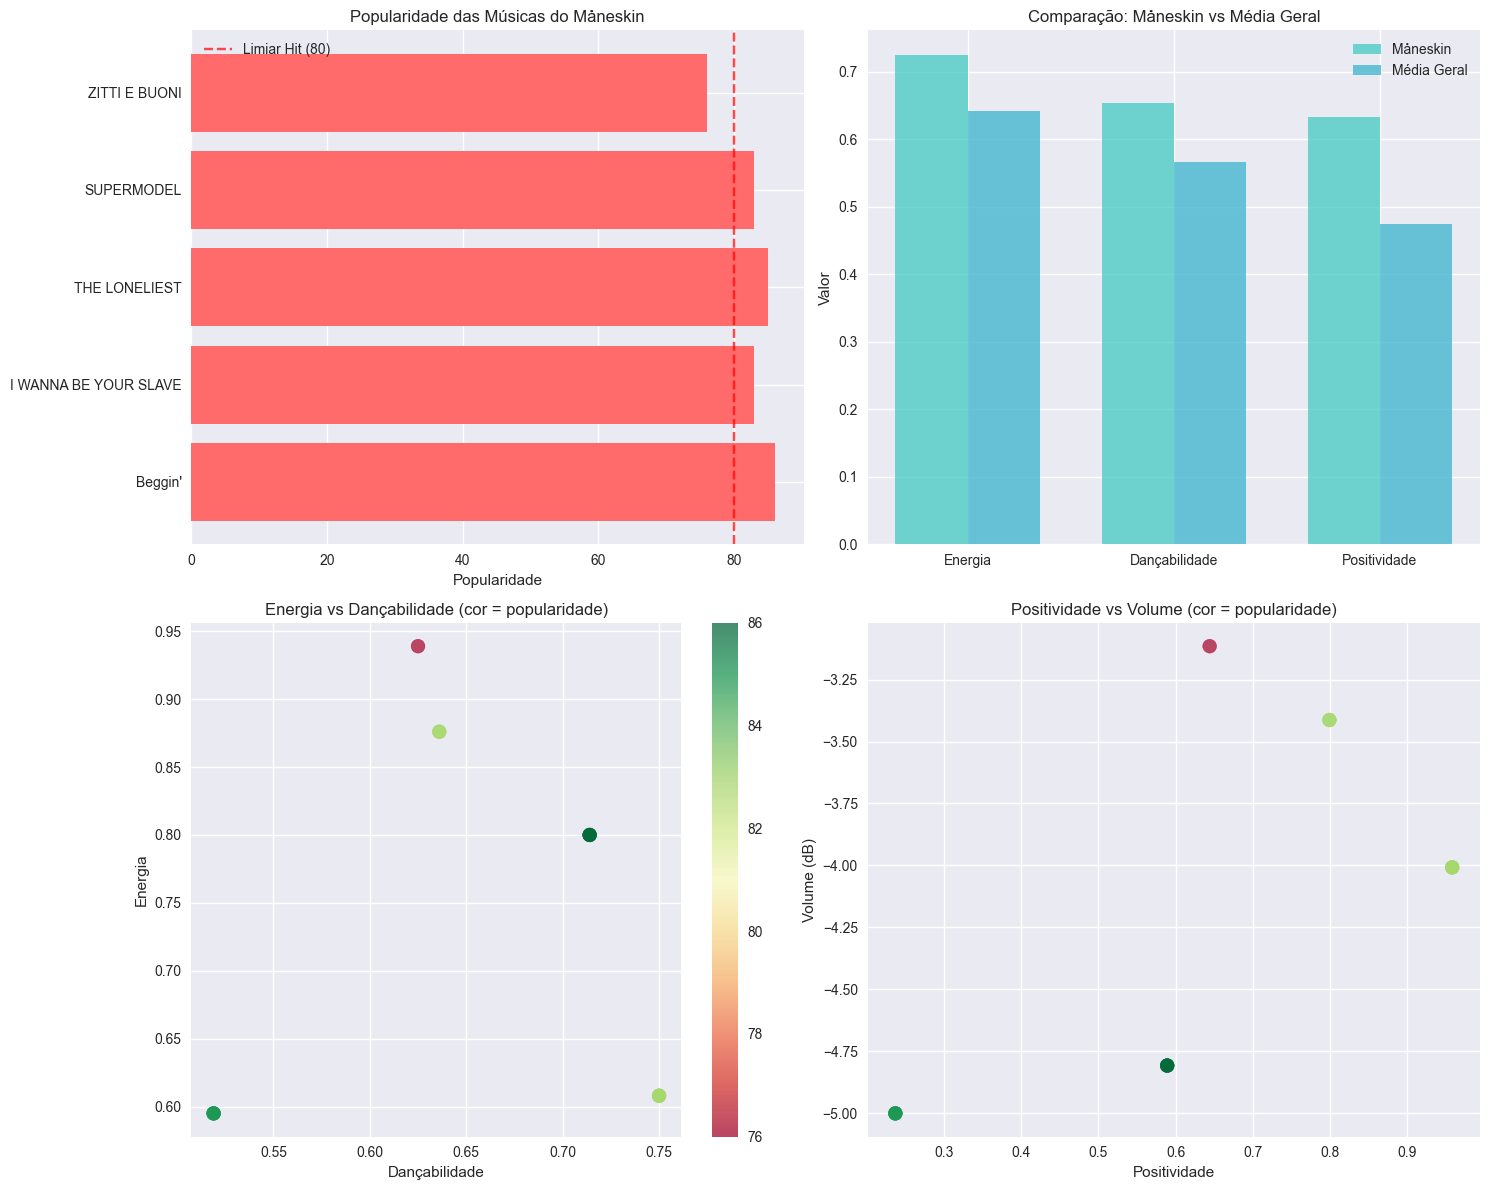


💡 INSIGHTS SOBRE O MÅNESKIN:
✅ O Måneskin tem 5.67 a mais de Andamento (BPM) que a média
🎯 O Måneskin tem uma taxa de hits 90.6% maior que a média

💾 Análise do Måneskin salva em: data/processed/maneskin_analysis.csv


In [15]:
# %% [markdown]
# ## 🎸 Análise das Músicas do Måneskin

# %%
print("🎸 ANALISANDO AS MÚSICAS DO MÅNESKIN...")
print("=" * 50)

# Filtrar músicas do Måneskin (considerando diferentes grafias)
maneskin_mask = df['artists'].str.contains('Måneskin|Maneskin', case=False, na=False)
maneskin_df = df[maneskin_mask].copy()

print(f"📊 Total de músicas do Måneskin no dataset: {len(maneskin_df)}")

if len(maneskin_df) > 0:
    # Mostrar todas as músicas do Måneskin
    print("\n🎵 MÚSICAS DO MÅNESKIN:")
    print("=" * 30)
    
    maneskin_display = maneskin_df[['track_name', 'album_name', 'popularity', 'is_hit']].copy()
    maneskin_display = maneskin_display.sort_values('popularity', ascending=False)
    display(maneskin_display.style.background_gradient(cmap='RdYlGn', subset=['popularity']))
    
    # Estatísticas do Måneskin
    print("\n📈 ESTATÍSTICAS DO MÅNESKIN:")
    print("=" * 30)
    
    total_maneskin = len(maneskin_df)
    hits_maneskin = maneskin_df['is_hit'].sum()
    taxa_hit_maneskin = (hits_maneskin / total_maneskin * 100)
    popularidade_media = maneskin_df['popularity'].mean()
    
    print(f"🎯 Músicas que são hits: {hits_maneskin}/{total_maneskin} ({taxa_hit_maneskin:.1f}%)")
    print(f"📊 Popularidade média: {popularidade_media:.1f}")
    print(f"⭐ Música mais popular: {maneskin_df.loc[maneskin_df['popularity'].idxmax(), 'track_name']} ({maneskin_df['popularity'].max()})")
    
    # Comparar com a média geral
    popularidade_media_geral = df['popularity'].mean()
    taxa_hit_geral = (df['is_hit'].sum() / len(df) * 100)
    
    print(f"\n📊 COMPARAÇÃO COM MÉDIA GERAL:")
    print(f"📈 Popularidade: {popularidade_media:.1f} (Måneskin) vs {popularidade_media_geral:.1f} (Geral)")
    print(f"🎯 Taxa de hits: {taxa_hit_maneskin:.1f}% (Måneskin) vs {taxa_hit_geral:.1f}% (Geral)")
    
    # Análise das características das músicas do Måneskin
    print("\n🎵 CARACTERÍSTICAS MUSICAIS DO MÅNESKIN:")
    print("=" * 40)
    
    caracteristicas_analise = ['danceability', 'energy', 'valence', 'acousticness', 'loudness', 'tempo']
    maneskin_caracteristicas = maneskin_df[caracteristicas_analise].mean()
    geral_caracteristicas = df[caracteristicas_analise].mean()
    
    comparacao_caracteristicas = pd.DataFrame({
        'Måneskin': maneskin_caracteristicas,
        'Média Geral': geral_caracteristicas,
        'Diferença': maneskin_caracteristicas - geral_caracteristicas
    }).round(3)
    
    display(comparacao_caracteristicas.style.background_gradient(cmap='RdBu_r', subset=['Diferença']))
    
    # Visualização comparativa
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Gráfico 1: Popularidade das músicas
    axes[0, 0].barh(maneskin_df['track_name'], maneskin_df['popularity'], color='#FF6B6B')
    axes[0, 0].axvline(80, color='red', linestyle='--', alpha=0.7, label='Limiar Hit (80)')
    axes[0, 0].set_xlabel('Popularidade')
    axes[0, 0].set_title('Popularidade das Músicas do Måneskin')
    axes[0, 0].legend()
    
    # Gráfico 2: Comparação de características
    características_plot = ['energy', 'danceability', 'valence']
    x = np.arange(len(características_plot))
    width = 0.35
    
    axes[0, 1].bar(x - width/2, maneskin_caracteristicas[características_plot], width, 
                   label='Måneskin', alpha=0.8, color='#4ECDC4')
    axes[0, 1].bar(x + width/2, geral_caracteristicas[características_plot], width, 
                   label='Média Geral', alpha=0.8, color='#45B7D1')
    axes[0, 1].set_ylabel('Valor')
    axes[0, 1].set_title('Comparação: Måneskin vs Média Geral')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([TRADUCOES_GRAFICOS.get(c, c) for c in características_plot])
    axes[0, 1].legend()
    
    # Gráfico 3: Distribuição de energia vs dançabilidade
    scatter = axes[1, 0].scatter(maneskin_df['danceability'], maneskin_df['energy'], 
                                c=maneskin_df['popularity'], cmap='RdYlGn', s=100, alpha=0.7)
    axes[1, 0].set_xlabel('Dançabilidade')
    axes[1, 0].set_ylabel('Energia')
    axes[1, 0].set_title('Energia vs Dançabilidade (cor = popularidade)')
    plt.colorbar(scatter, ax=axes[1, 0])
    
    # Gráfico 4: Positividade vs Volume
    axes[1, 1].scatter(maneskin_df['valence'], maneskin_df['loudness'], 
                      c=maneskin_df['popularity'], cmap='RdYlGn', s=100, alpha=0.7)
    axes[1, 1].set_xlabel('Positividade')
    axes[1, 1].set_ylabel('Volume (dB)')
    axes[1, 1].set_title('Positividade vs Volume (cor = popularidade)')
    
    plt.tight_layout()
    plt.show()
    
    # Insights específicos
    print("\n💡 INSIGHTS SOBRE O MÅNESKIN:")
    print("=" * 30)
    
    # Característica mais destacada
    diff_max = comparacao_caracteristicas['Diferença'].abs().idxmax()
    diff_val = comparacao_caracteristicas.loc[diff_max, 'Diferença']
    
    if diff_val > 0:
        print(f"✅ O Måneskin tem {abs(diff_val):.2f} a mais de {TRADUCOES_GRAFICOS.get(diff_max, diff_max)} que a média")
    else:
        print(f"❌ O Måneskin tem {abs(diff_val):.2f} a menos de {TRADUCOES_GRAFICOS.get(diff_max, diff_max)} que a média")
    
    # Análise do sucesso
    if taxa_hit_maneskin > taxa_hit_geral:
        print(f"🎯 O Måneskin tem uma taxa de hits {taxa_hit_maneskin - taxa_hit_geral:.1f}% maior que a média")
    else:
        print(f"📉 O Måneskin tem uma taxa de hits {taxa_hit_geral - taxa_hit_maneskin:.1f}% menor que a média")
        
    # Salvar análise
    maneskin_df.to_csv('data/processed/maneskin_analysis.csv', index=False)
    print(f"\n💾 Análise do Måneskin salva em: data/processed/maneskin_analysis.csv")
    
else:
    print("❌ Nenhuma música do Måneskin encontrada no dataset.")
    print("💡 Verifique se o nome está escrito como 'Måneskin' no dataset")